# ENVIRONMENT

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# ACQUIRE

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


## Parse timestamp

In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

## Cleanup text

In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,52.91.30.150,1,0.000072
10,34.229.70.250,1,0.000072
11,3.92.201.136,1,0.000072
12,95.31.16.121,1,0.000072
13,35.174.209.2,1,0.000072


22
               ip  ip_count  ip_proba
12   95.31.16.121         1  0.000072
13   35.174.209.2         1  0.000072
14  97.105.15.120         1  0.000072
15  54.172.14.223         1  0.000072
16   45.23.250.16         1  0.000072
17  54.145.52.184         1  0.000072
18  52.90.165.200         1  0.000072
19  34.207.64.242         1  0.000072
20   95.31.18.119         1  0.000072
21   3.88.129.158         1  0.000072


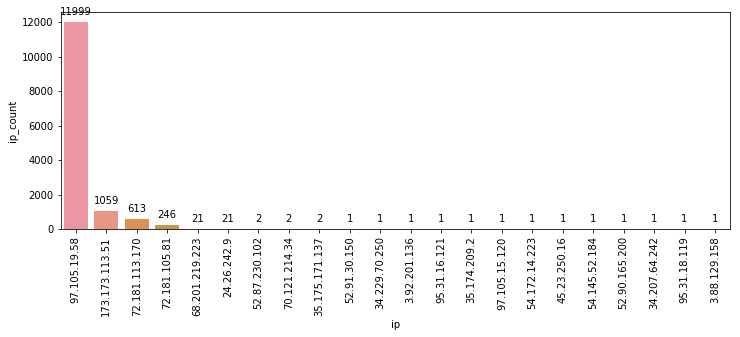

In [10]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [11]:
df.head(10)

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,NaN,python-requests/2.21.0,0.001266
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0,0.487092
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,NaN,python-requests/2.21.0,0.486706
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,NaN,python-requests/2.21.0,0.000040


In [12]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [13]:
train.head(10)

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,NaN,python-requests/2.21.0,0.001266
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0,0.487092
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,NaN,python-requests/2.21.0,0.486706
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,NaN,python-requests/2.21.0,0.000040


In [14]:
request_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})

In [15]:
request_df

,request_agent,request_agent_proba
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [16]:
df = df.reset_index().merge(request_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.request_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [17]:
request_probs = train.groupby('request_agent').size().div(len(df))

status_given_request = pd.DataFrame(train.groupby(['request_agent', 'status']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_request'})
                              )

In [18]:
request_status_count = pd.DataFrame(train.groupby(['request_agent', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'request_status_count'}))


request_status = status_given_request.merge(request_status_count)

In [19]:
df = df.reset_index().merge(request_status, on=['request_agent', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [20]:
df.head(10)

,ip,request_method,status,size,destination,request_agent,size_mb,request_agent_proba,proba_status_given_request,request_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858809,0.999286,11989.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858809,0.999286,11989.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858809,0.999286,11989.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858809,0.999286,11989.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858809,0.999286,11989.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.858809,0.999286,11989.0
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,0,python-requests/2.21.0,0.487092,0.858809,0.999286,11989.0
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,0,python-requests/2.21.0,0.486706,0.858809,0.999286,11989.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,0,python-requests/2.21.0,0.000040,0.858809,0.999286,11989.0


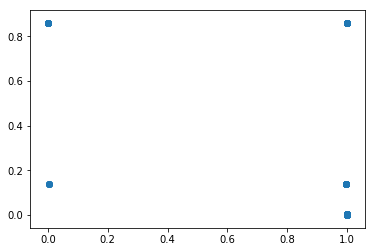

In [21]:
plt.scatter(df.proba_status_given_request, df.request_agent_proba)

# Stats & Time-Series

In [22]:
df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 10 columns):
ip                            13978 non-null object
request_method                13978 non-null object
status                        13978 non-null int64
size                          13978 non-null int64
destination                   13978 non-null object
request_agent                 13978 non-null object
size_mb                       13978 non-null float64
request_agent_proba           13978 non-null float64
proba_status_given_request    13978 non-null float64
request_status_count          13978 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.2+ MB


## Train/Test Split

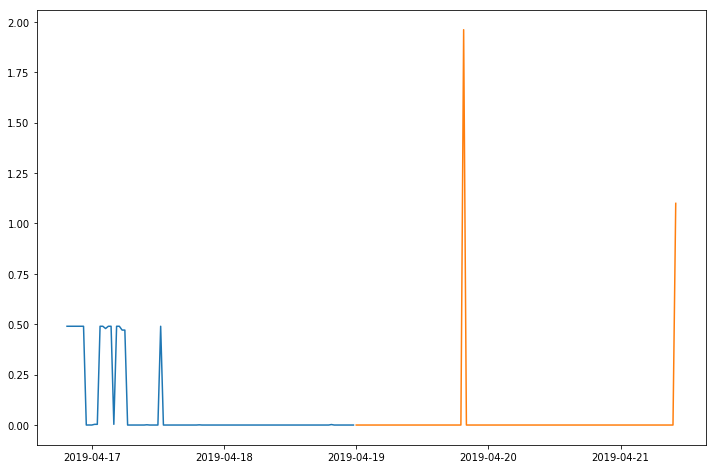

In [24]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-18 23:30:00'
start_date_test = '2019-04-19 00:00:00'

train_ts_size = df_ts_size[:end_date_train]
test_ts_size = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train_ts_size)
plt.plot(test_ts_size)
plt.show()

## SMA - Simple Moving Average

In [25]:
# Calculating the short-window simple moving average
short_rolling = train_ts_size.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train_ts_size.rolling(window=24).mean()

In [27]:
# fig, ax = plt.subplots(figsize=(12,4))

# ax.plot(train_ts_size.index, 
#         train,
#         label='Size (MB)')

# ax.plot(short_rolling.index, 
#         short_rolling, 
#         label = '6-Hour SMA')
# ax.plot(long_rolling.index, 
#         long_rolling, 
#         label = '12-Hour SMA')

# ax.legend(loc='best')
# ax.set_ylabel('Size (MB)')

## Compute the EMA

In [28]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train_ts_size.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train_ts_size.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2019-04-16 19:30:00    0.489937
2019-04-16 20:00:00    0.489937
2019-04-16 20:30:00    0.489937
Freq: 30T, Name: size_mb, dtype: float64

## Compare SMA with EMA

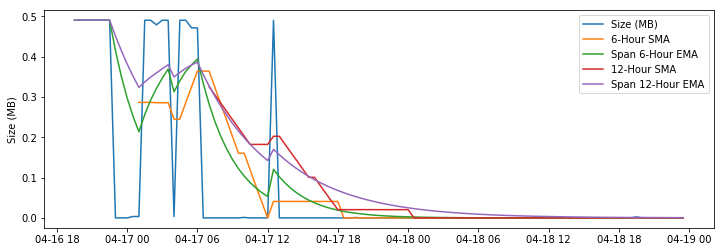

In [29]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train_ts_size.index, 
        train_ts_size,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test_ts_size))

# Forecast using the EMA

In [30]:
ema_long = train_ts_size.ewm(span=24, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

## Compute the `%b` for each record

In [31]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

## Extract the anomalies

In [32]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00,1.961066,0.000597,1.960469,402.911854
2019-04-21 10:00:00,1.099591,0.000597,1.098994,226.082897


# RIGHTIE - OH

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 10 columns):
ip                            13978 non-null object
request_method                13978 non-null object
status                        13978 non-null int64
size                          13978 non-null int64
destination                   13978 non-null object
request_agent                 13978 non-null object
size_mb                       13978 non-null float64
request_agent_proba           13978 non-null float64
proba_status_given_request    13978 non-null float64
request_status_count          13978 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.2+ MB


In [34]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,request_agent_proba,proba_status_given_request,request_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858809,0.999286,11989.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858809,0.999286,11989.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858809,0.999286,11989.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858809,0.999286,11989.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858809,0.999286,11989.0


# DBSCAN

In [36]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [37]:
# Import .csv file and convert it to a DataFrame object
df = pd.read_csv("customers.csv")

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [38]:
# df.drop(["Channel", "Region"], axis = 1, inplace = True)
df = df[["Grocery", "Milk","Fresh"]]

In [39]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 7561.,  9656., 12669.],
       [ 9568.,  9810.,  7057.],
       [ 7684.,  8808.,  6353.],
       [ 4221.,  1196., 13265.],
       [ 7198.,  5410., 22615.],
       [ 5126.,  8259.,  9413.],
       [ 6975.,  3199., 12126.],
       [ 9426.,  4956.,  7579.],
       [ 6192.,  3648.,  5963.],
       [18881., 11093.,  6006.]], dtype=float32)

In [40]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.0411149 ,  0.5235678 ,  0.05293319],
       [ 0.17031837,  0.5444577 , -0.39130196],
       [-0.0281571 ,  0.40853772, -0.44702926],
       [-0.3929769 , -0.62402   ,  0.1001114 ],
       [-0.07935619, -0.05239645,  0.8402394 ],
       [-0.29763708,  0.3340666 , -0.20480551],
       [-0.10284877, -0.35231563,  0.00995035],
       [ 0.15535896, -0.11398095, -0.34998146],
       [-0.18533617, -0.2914094 , -0.4779009 ],
       [ 1.1514235 ,  0.7184949 , -0.4744971 ]], dtype=float32)

In [41]:
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

In [42]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
df['labels'] = labels
df.labels.value_counts()

 0    400
-1     40
Name: labels, dtype: int64

In [44]:
df[df.labels==-1].head()

,Grocery,Milk,Fresh,labels
12,11757,12319,31714,-1
23,22019,36423,26373,-1
28,25957,20484,4113,-1
39,902,555,56159,-1
45,21531,22044,5181,-1


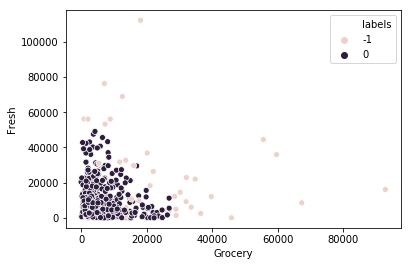

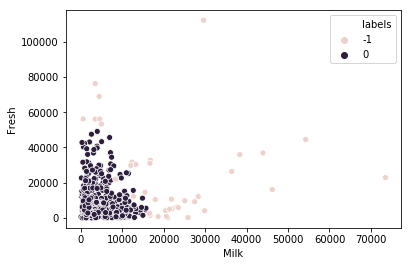

In [45]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

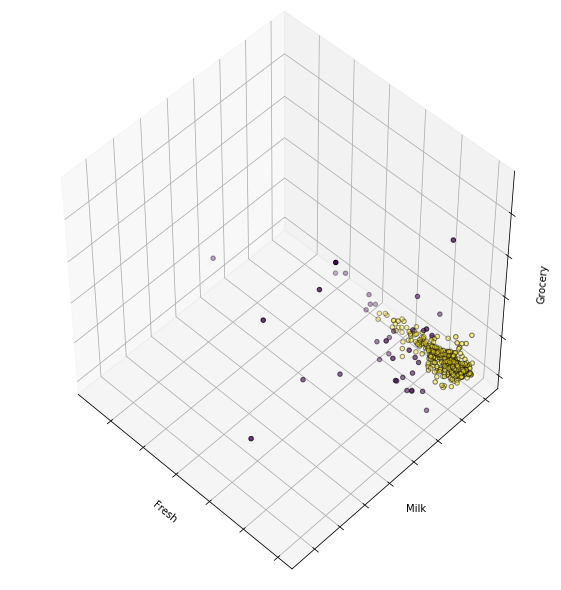

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')